In [1]:
import torch
print(f"Device: {torch.cuda.current_device()}")
print(f"Total GPUs: {torch.cuda.device_count()}")


Device: 0
Total GPUs: 2


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from datasets import load_dataset, Dataset
from transformers import Trainer, TrainingArguments
import numpy as np

# 1. Setup & Imports

# Check if CUDA is available and if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# 2. Dataset Preparation

# Load CIFAR-10 dataset
dataset = load_dataset("cifar10")


# Image Transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize for ResNet
])


def transform_images(examples):
    images = [transform(image.convert("RGB")) for image in examples['img']]
    return {"pixel_values": images, "labels": examples['label']}


# Apply transformation and convert to HF Dataset
train_dataset = dataset["train"].map(transform_images, batched=True, remove_columns=["img"])
test_dataset = dataset["test"].map(transform_images, batched=True, remove_columns=["img"])

train_dataset

Using device: cuda


Dataset({
    features: ['label', 'pixel_values', 'labels'],
    num_rows: 50000
})

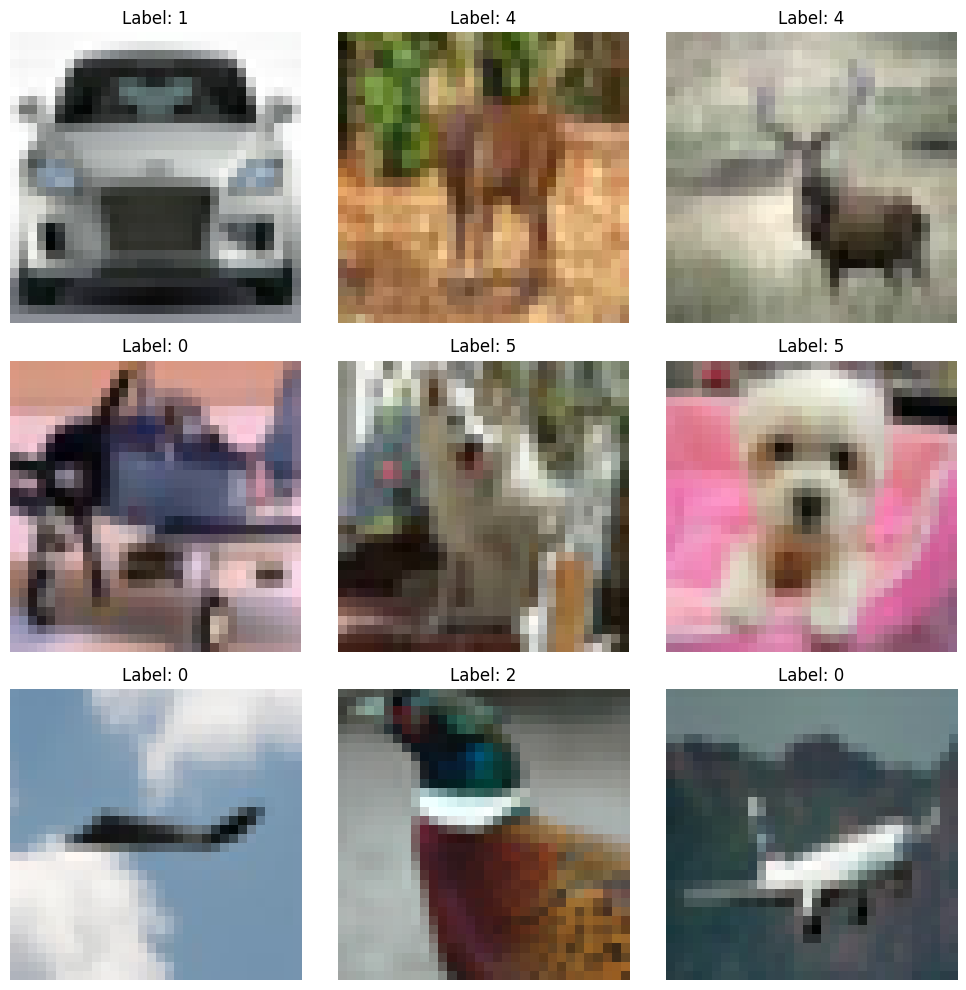

In [3]:
import random
import matplotlib.pyplot as plt

# Step 1: Randomly select 9 samples
indices = random.sample(range(len(train_dataset)), 9)
selected_samples = train_dataset.select(indices)

# Step 2: Plot the images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    # Extract the image and label
    image = selected_samples[i]['pixel_values']  # Assuming this is a tensor or numpy array
    label = selected_samples[i]['label']  # Adjust according to dataset field name

    image = np.array(image)
    # Rescale the image from [-1, 1] to [0, 1]
    image = (image - image.min()) / (image.max() - image.min())
    
    # Convert image tensor to proper format for display
    if isinstance(image, torch.Tensor):  # If image is a torch tensor
        image = image.squeeze().numpy()  # Remove singleton dimensions and convert to numpy
    elif len(image.shape) == 3 and image.shape[0] in [1, 3]:  # Channel-first format
        image = image.transpose(1, 2, 0)  # Convert to channel-last format
    
    # Plot the image
    ax.imshow(image, cmap='gray' if len(image.shape) == 2 else None)  # Use 'gray' for 2D images
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [4]:
# Set output format to torch to not mess up Trainer
train_dataset.set_format("torch", columns=["pixel_values","labels"])
test_dataset.set_format("torch", columns=["pixel_values","labels"])

print(train_dataset)
print(test_dataset)
print("Sample dataset output:", train_dataset[0]) # Double check this



Dataset({
    features: ['label', 'pixel_values', 'labels'],
    num_rows: 50000
})
Dataset({
    features: ['label', 'pixel_values', 'labels'],
    num_rows: 10000
})
Sample dataset output: {'pixel_values': tensor([[[ 0.3961,  0.3961,  0.3961,  ...,  0.3333,  0.3176,  0.2941],
         [ 0.4118,  0.4039,  0.4118,  ...,  0.3569,  0.3412,  0.3176],
         [ 0.3882,  0.3882,  0.3961,  ...,  0.3412,  0.3255,  0.3098],
         ...,
         [-0.1216, -0.1137, -0.1059,  ..., -0.2157, -0.2314, -0.2078],
         [-0.1216, -0.1216, -0.1137,  ..., -0.2000, -0.2000, -0.2000],
         [-0.1922, -0.2157, -0.1922,  ..., -0.2784, -0.2706, -0.2863]],

        [[ 0.3804,  0.3804,  0.3804,  ...,  0.3176,  0.3020,  0.2784],
         [ 0.3961,  0.3882,  0.3961,  ...,  0.3412,  0.3255,  0.3020],
         [ 0.3725,  0.3725,  0.3804,  ...,  0.3255,  0.3098,  0.2941],
         ...,
         [-0.1608, -0.1451, -0.1373,  ..., -0.2392, -0.2627, -0.2549],
         [-0.2000, -0.1922, -0.1922,  ..., -0.2549, 

In [5]:
train_dataset[0]['labels']

tensor(0)

In [6]:
train_dataset[0]['pixel_values']

tensor([[[ 0.3961,  0.3961,  0.3961,  ...,  0.3333,  0.3176,  0.2941],
         [ 0.4118,  0.4039,  0.4118,  ...,  0.3569,  0.3412,  0.3176],
         [ 0.3882,  0.3882,  0.3961,  ...,  0.3412,  0.3255,  0.3098],
         ...,
         [-0.1216, -0.1137, -0.1059,  ..., -0.2157, -0.2314, -0.2078],
         [-0.1216, -0.1216, -0.1137,  ..., -0.2000, -0.2000, -0.2000],
         [-0.1922, -0.2157, -0.1922,  ..., -0.2784, -0.2706, -0.2863]],

        [[ 0.3804,  0.3804,  0.3804,  ...,  0.3176,  0.3020,  0.2784],
         [ 0.3961,  0.3882,  0.3961,  ...,  0.3412,  0.3255,  0.3020],
         [ 0.3725,  0.3725,  0.3804,  ...,  0.3255,  0.3098,  0.2941],
         ...,
         [-0.1608, -0.1451, -0.1373,  ..., -0.2392, -0.2627, -0.2549],
         [-0.2000, -0.1922, -0.1922,  ..., -0.2549, -0.2706, -0.2784],
         [-0.2471, -0.2706, -0.2549,  ..., -0.3412, -0.3255, -0.3412]],

        [[ 0.4824,  0.4824,  0.4824,  ...,  0.4118,  0.3882,  0.3647],
         [ 0.4980,  0.4902,  0.4980,  ...,  0

In [7]:

# 3. Model Definition

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion*out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion*out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(identity)
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, pixel_values, labels=None):
        x = pixel_values
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        logits = self.fc(out)

        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return {"loss": loss, "logits": logits}




model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10)
model.to(device)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [ ]:
import numpy as np
from transformers import Trainer, TrainingArguments
import os
from sklearn.metrics import f1_score

# Define a TensorBoard directory
tensorboard_dir = "./logs"

# Create a TrainingArguments instance
training_args = TrainingArguments(
    output_dir="./resnet_cifar10",
    per_device_train_batch_size=512,  # Effective batch size = batch_size * num_GPUs
    per_device_eval_batch_size=512,
    gradient_accumulation_steps=1,  # Adjust if needed
    num_train_epochs=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir=tensorboard_dir,
    logging_steps=10,  # Log metrics every 10 steps
    load_best_model_at_end=True,
    learning_rate=1e-3,
    weight_decay=1e-4,
    dataloader_num_workers=10,
    report_to=["tensorboard"],  # Log results to TensorBoard
)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to predicted class indices
    predictions = np.argmax(logits, axis=-1)
    
    # Calculate accuracy
    accuracy = np.mean(predictions == labels)
    
    # Calculate F1 score (supports multi-class classification)
    f1 = f1_score(labels, predictions, average='weighted')  # 'weighted' handles class imbalance
    
    return {"accuracy": accuracy, "f1": f1}




# Initialize the Trainer with the TensorBoard callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.274100,1.445818,0.502200,0.492712
2,0.957000,1.064368,0.621800,0.619649
3,0.796700,0.970894,0.664100,0.662810
4,0.673100,0.945024,0.685500,0.684236
5,0.554100,0.959739,0.691800,0.690267
6,0.461200,0.950952,0.701500,0.704032
7,0.329400,1.026668,0.694100,0.694204
8,0.300900,1.096900,0.704600,0.705317
9,0.236800,1.157594,0.709400,0.710615
10,0.192700,1.373513,0.693900,0.687071


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir ./logs --host='0.0.0.0' --port=6006
